<a href="https://colab.research.google.com/github/marriamaslova/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [ ]:
! pip install transformers

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

bert-base-multilingual-cased

In [ ]:
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
X = []

for text in data.title:
    ids = tokenizer_bert.encode(text)
    
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf_bert = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# лосс нужно поставить поменьше
model_clf_bert.compile(tf.optimizers.Adam(learning_rate=2e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80)])

In [ ]:
model_clf_bert.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=12,
         epochs=20)

Epoch 1/20


48/48 [==============================] - 108s 2s/step - loss: 2.9067 - accuracy: 0.0868 - recall_at_precision: 0.0000e+00 - val_loss: 2.7284 - val_accuracy: 0.0645 - val_recall_at_precision: 0.0000e+00
Epoch 2/20
48/48 [==============================] - 72s 1s/step - loss: 2.8271 - accuracy: 0.0990 - recall_at_precision: 0.0000e+00 - val_loss: 2.6933 - val_accuracy: 0.0968 - val_recall_at_precision: 0.0000e+00
Epoch 3/20
48/48 [==============================] - 71s 1s/step - loss: 2.7888 - accuracy: 0.0972 - recall_at_precision: 0.0017 - val_loss: 2.6725 - val_accuracy: 0.0968 - val_recall_at_precision: 0.0000e+00
Epoch 4/20
48/48 [==============================] - 70s 1s/step - loss: 2.8071 - accuracy: 0.0608 - recall_at_precision: 0.0000e+00 - val_loss: 2.6834 - val_accuracy: 0.1290 - val_recall_at_precision: 0.0000e+00
Epoch 5/20
48/48 [==============================] - 72s 1s/step - loss: 2.7627 - accuracy: 0.0851 - recall_at_precision: 0.0000e+00 - val_loss: 2.6656 - val_accuracy:

dict_keys(['loss', 'accuracy', 'recall_at_precision', 'val_loss', 'val_accuracy', 'val_recall_at_precision'])


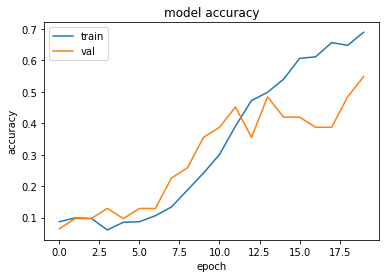

In [ ]:
print(model_clf_bert.history.history.keys())
plt.plot(model_clf_bert.history.history['accuracy'])
plt.plot(model_clf_bert.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf_bert.predict(X_valid).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

           Бизнес       0.50      1.00      0.67         2
         Культура       0.67      0.67      0.67         3
         Из жизни       1.00      0.67      0.80         3
  Наука и техника       0.75      1.00      0.86         3
           Россия       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
      Бывший СССР       0.67      0.67      0.67         3
            Спорт       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
              Дом       0.33      0.50      0.40         2
       Библиотека       0.00      0.00      0.00         0
   Интернет и СМИ       1.00      0.50      0.67         2
Силовые структуры       0.33      1.00      0.50         2
              Мир       0.00      0.00      0.00         1
         Ценности       0.50      0.50      0.50       

distilbert-base-multilingual-cased

In [ ]:
tokenizer_db = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_db = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:
X = []

for text in data.title:
    ids = tokenizer_db.encode(text)
    
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_db({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf_db = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# лосс нужно поставить поменьше
model_clf_db.compile(tf.optimizers.Adam(learning_rate=2e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80)])

In [ ]:
model_clf_db.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=12,
         epochs=20)

Epoch 1/20
48/48 [==============================] - 53s 730ms/step - loss: 2.8612 - accuracy: 0.0712 - recall_at_precision: 0.0000e+00 - val_loss: 2.7276 - val_accuracy: 0.0968 - val_recall_at_precision: 0.0000e+00
Epoch 2/20
48/48 [==============================] - 32s 676ms/step - loss: 2.7616 - accuracy: 0.0764 - recall_at_precision: 0.0000e+00 - val_loss: 2.7169 - val_accuracy: 0.0968 - val_recall_at_precision: 0.0000e+00
Epoch 3/20
48/48 [==============================] - 33s 680ms/step - loss: 2.7496 - accuracy: 0.0990 - recall_at_precision: 0.0000e+00 - val_loss: 2.7089 - val_accuracy: 0.0968 - val_recall_at_precision: 0.0000e+00
Epoch 4/20
48/48 [==============================] - 33s 697ms/step - loss: 2.7426 - accuracy: 0.0920 - recall_at_precision: 0.0000e+00 - val_loss: 2.6958 - val_accuracy: 0.1290 - val_recall_at_precision: 0.0000e+00
Epoch 5/20
48/48 [==============================] - 34s 701ms/step - loss: 2.7385 - accuracy: 0.0903 - recall_at_precision: 0.0000e+00 - val

dict_keys(['loss', 'accuracy', 'recall_at_precision', 'val_loss', 'val_accuracy', 'val_recall_at_precision'])


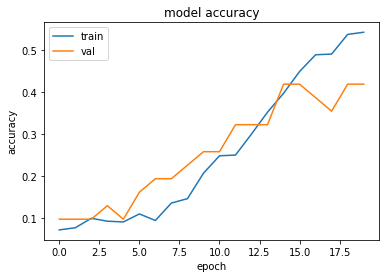

In [ ]:
print(model_clf_db.history.history.keys())
plt.plot(model_clf_db.history.history['accuracy'])
plt.plot(model_clf_db.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred_db = model_clf_db.predict(X_valid).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred_db, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

            Спорт       1.00      1.00      1.00         2
   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
   Интернет и СМИ       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
         Из жизни       0.25      0.33      0.29         3
              Дом       1.00      0.50      0.67         2
           Бизнес       0.25      0.50      0.33         2
      Бывший СССР       0.60      1.00      0.75         3
         Культура       1.00      0.67      0.80         3
  Наука и техника       0.67      0.67      0.67         3
Силовые структуры       0.17      0.50      0.25         2
             Крым       0.00      0.00      0.00         0
        Экономика       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00       

DeepPavlov
/
bert-base-bg-cs-pl-ru-cased aka SlavicBERT

In [ ]:
tokenizer_rb = AutoTokenizer.from_pretrained('DeepPavlov/bert-base-bg-cs-pl-ru-cased')
model_rb = TFAutoModel.from_pretrained('DeepPavlov/bert-base-bg-cs-pl-ru-cased', from_pt=True)

In [ ]:
X = []

for text in data.title:
    ids = tokenizer_rb.encode(text)
    
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_rb({"input_ids":input_word_ids})

# добавим дропаут чтобы не переобучалось
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0])
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf_rb = tf.keras.Model(inputs=input_word_ids, outputs=dense)

# лосс нужно поставить поменьше
model_clf_rb.compile(tf.optimizers.Adam(learning_rate=2e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80)])

In [ ]:
model_clf_rb.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=12,
         epochs=20)

Epoch 1/20


48/48 [==============================] - 121s 2s/step - loss: 2.9014 - accuracy: 0.0972 - recall_at_precision: 0.0000e+00 - val_loss: 2.7061 - val_accuracy: 0.0645 - val_recall_at_precision: 0.0000e+00
Epoch 2/20
48/48 [==============================] - 76s 2s/step - loss: 2.8158 - accuracy: 0.0799 - recall_at_precision: 0.0000e+00 - val_loss: 2.7229 - val_accuracy: 0.1290 - val_recall_at_precision: 0.0000e+00
Epoch 3/20
48/48 [==============================] - 74s 2s/step - loss: 2.7984 - accuracy: 0.0955 - recall_at_precision: 0.0000e+00 - val_loss: 2.7773 - val_accuracy: 0.1290 - val_recall_at_precision: 0.0000e+00
Epoch 4/20
48/48 [==============================] - 74s 2s/step - loss: 2.7419 - accuracy: 0.1215 - recall_at_precision: 0.0000e+00 - val_loss: 2.6717 - val_accuracy: 0.2258 - val_recall_at_precision: 0.0000e+00
Epoch 5/20
48/48 [==============================] - 76s 2s/step - loss: 2.6562 - accuracy: 0.1372 - recall_at_precision: 0.0000e+00 - val_loss: 2.5718 - val_accur

dict_keys(['loss', 'accuracy', 'recall_at_precision', 'val_loss', 'val_accuracy', 'val_recall_at_precision'])


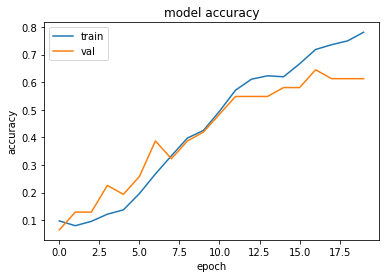

In [ ]:
print(model_clf_rb.history.history.keys())
plt.plot(model_clf_rb.history.history['accuracy'])
plt.plot(model_clf_rb.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred_rb = model_clf_rb.predict(X_valid).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred_rb, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

        Экономика       1.00      1.00      1.00         2
         Культура       0.67      0.67      0.67         3
              Дом       0.40      1.00      0.57         2
           Россия       0.33      0.50      0.40         2
              Мир       0.33      1.00      0.50         1
      Бывший СССР       1.00      0.33      0.50         3
         Из жизни       1.00      0.33      0.50         3
Силовые структуры       0.67      1.00      0.80         2
       Библиотека       0.00      0.00      0.00         0
             Крым       0.00      0.00      0.00         0
         Ценности       0.50      0.50      0.50         2
            Спорт       1.00      1.00      1.00         2
   69-я параллель       0.00      0.00      0.00         1
  Наука и техника       1.00      0.67      0.80         3
           Бизнес       0.50      0.50      0.50         2
          Легпром       0.00      0.00      0.00       

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

1. RoBERTa была представлена в статье "RoBERTa: A Robustly Optimized BERT Pretraining Approach" (Yinhan Liu, Myle Ott, Naman Goyal et al.) в 2019 году. Ее архитектура очень схожа с BERT, но разработчики добавили следующие оптимизации:


*   Больший размер batches и словаря при тренировке модели 
*   Более длительное время обучения и больший объем обучающих данных (в 10 раз больше — от 16GB к 160GB)
*   В качестве входных данных используются более длинные последовательности, но RoBERTa по-прежнему имеет ограничение на максимальное количество токенов — 512
*   В BERT маскирование происходит один раз. В RoBERTa применяется динамическое маскирование. Обучающие данные дублируются и маскируются 10 раз в течение 40 epochs, таким образом, на один вариант маскирования приходится 4 эпохи. 



2. T5 "переформулирует" все задачи NLP в единый формат text-to-text, где input и output всегда представляют собой текстовые строки, в отличие от BERT-based моделей, которые могут выводить только метку класса или диапазон входных данных. Такой text-to-text framework позволяет  использовать одну и ту же модель, функцию потерь и гиперпараметры в любой задаче NLP, включая машинный перевод, обобщение документов, ответы на вопросы и задачи классификации